# Uso del módulo fordward MoM comparado con analítico

En el módulo *forward* se implementan algunas formas de resolución del problema directo de imágenes por microondas de un arreglo circular de antenas. En este apartado comparamos la solución del Método de los Momentos con la analítica comentada en el apartado anterior.

Libros y publicaciones:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

[2] Matteo Pastorino, Microwave Imaging


Módulo Python: forward

Autores: Ramiro Irastorza 

Email: rirastorza@iflysib.unlp.edu.ar


## Ejemplo de uso para validación con modelo teórico analítico

Primero, se cargan los paquetes necesarios.

In [1]:
from forward import *
import time as tm
import os
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import numpy as np
from scipy import constants as S
from scipy import special


### Modelo analítico y numérico con FDTD

El modelo analítico lo implementamos según S. Arslanagic y O. Breinbjerg (2006) [enlace](https://ieeexplore.ieee.org/document/1703397). Es un modelo Transversal Magnético con un campo cilíndrico excitado en dirección z. La implementación es con un cilindro centrado en el origen (0,0) solamente, no se puede modificar el centro del cilindro (igual al tutorial anterior). Se define la frecuencia, el tamaño de la caja de simulación 25 cm x 25 cm, donde está el arreglo de n antenas (en el ejemplo 4 antenas). Se crean los objetos _TRANSMISOR_parameters_ y _ACOPLANTE_parameters_ y se les asignan las propiedades. Estos objetos contienen información del arreglo de antenas y del fluido de acoplamiento, respectivamente. El acoplante, en este ejemplo, tendrá $\varepsilon_{rb} = 40.0$ y $\sigma_{b}=0.5$, la b es de background. El cilindro tendrá $\varepsilon_{r} = 50.0$ y $\sigma = 0.4$ y radio 25 mm.

frecuencia de medición (GHz):  1.1
Xc: 0.0 Yc: 0.0 r: 0.025


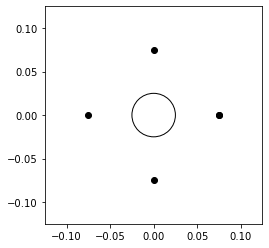

Permitividad medio: 40.0
Conductividad medio: 0.5
Permitividad del cilindro: 50.0
Conductividad del cilindro: 0.4


In [2]:
start_time = tm.strftime('%H:%M:%S')
f = 1.1e9
print('frecuencia de medición (GHz): ',f/1e9)
sx = 0.25
sy = 0.25
box = [sx,sy]
TRANSMISOR_parameters = TRANSMISOR_parameters()
TRANSMISOR_parameters.f = f
TRANSMISOR_parameters.amp = 7.5e4
TRANSMISOR_parameters.rhoS = 0.075
TRANSMISOR_parameters.S = 4.
#Coordenadas antenas
angulo = N.linspace(0.0, 2.0*pi, 5)
xantenas = (TRANSMISOR_parameters.rhoS)*N.cos(angulo)
yantenas = (TRANSMISOR_parameters.rhoS)*N.sin(angulo)

#Generación de modelos
r = 25.0e-3
Xc = 0.0
Yc = 0.0
print('Xc:', Xc,'Yc:', Yc,'r:',r)
#Dibujo la geometría generada
figure, axes = plt.subplots()
cilindro = plt.Circle((Xc,Yc),r,fill = False)
plt.xlim(-0.25/2, 0.25/2)
plt.ylim(-0.25/2 , 0.25/2)
axes.set_aspect(1)
axes.add_artist(cilindro)
axes.plot(xantenas,yantenas,'ok')
plt.show()

ACOPLANTE_parameters = ACOPLANTE_parameters()
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = 40.0
ACOPLANTE_parameters.sigma = 0.5 
#Comienzo de simulación
cilindro1 = SCATTERER_parameters()
cilindro1.epsr = 50.0
cilindro1.sigma = 0.4
cilindro1.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro1.radio = r
cilindro1.xc = Xc
cilindro1.yc = Yc
print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)
print('Permitividad del cilindro:',cilindro1.epsr)
print('Conductividad del cilindro:',cilindro1.sigma)

La función que resuelve el problema analítico se llama: _EZ_CILINDER_LINESOURCE_MATRIZ(eps_data,cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,tx,deltaX)_. Las entradas son similares a la de la función _Runmeep_ con la diferencia que el primer argumento _eps_data_ es una variable que se utiliza para obtener la grilla discreta donde se quiere calcular el campo. Esta grilla se saca de Meep, en consecuencia primero se debe correr la simulación FDTD con _Runmeep_ y luego la analítica. La salida de la función es una matriz compleja con el valor del campo $E_{z}$ en cada punto de la grilla. Compararemos entonces Analítico con FDTD y con MoM.

sxa:  50.0 sxa:  50.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000432968 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (50,50,50)
time for set_epsilon = 0.077939 s
time for set_conductivity = 0.00422597 s
time for set_conductivity = 0.00440907 s
time for set_conductivity = 0.00442886 s
-----------
Meep: using complex fields.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 413.70000000000005/600.0 = 69.0% done in 4.0s, 1.8s to go
on time step 4149 (time=414.9), 0.000964218 s/step
run 0 finished at t = 600.0 (6000 timesteps)


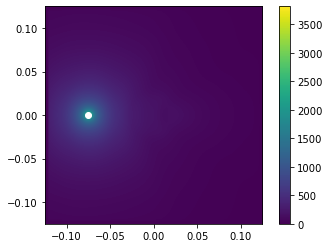

In [3]:
resolucion = 5
n = resolucion*sx/a
tx = 2
xS = (0.15/2)*N.cos(tx*2*pi/4.) #Coordenada x antena emisora
yS = (0.15/2)*N.sin(tx*2*pi/4.)
Ezfdtd,eps_data = RunMeep(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx, box,RES = resolucion,calibration = False)

plt.figure()
extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(abs(Ezfdtd).transpose(),extent = extent2)#cmap = 'binary')
plt.plot(xS,yS,'ow')
plt.colorbar()
#Dibujo el mapa de permitividad
NN = len(eps_data)
deltaX = sx/(NN)

Ahora calculamos la solución analítica, mediante.

In [10]:
x,Eztheory1 = EZ_CILINDER_LINESOURCE_MATRIZ(eps_data,cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,tx,deltaX)

Luego dibujamos y comparamos en la posición x = 0, para todo y. 

### Modelo con el Método de los Momentos

Resuelvo con el método de los momentos y comparo con los anteriores.

In [ ]:
Et_mom = RunMoM(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters,box,RES = 200)

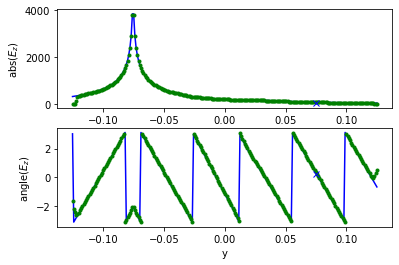

start time:  14:02:06
end time:    14:22:44


In [22]:
x = np.linspace(-len(eps_data)*deltaX/2., len(eps_data)*deltaX/2., len(eps_data))

fig2 = plt.figure(2)
f2 = fig2.add_subplot(211)
f2.plot(x,abs(Eztheory1[:,int(len(Eztheory1)/2)]),'b')
f2.plot(x,abs(Ezfdtd[:,int(len(Ezfdtd)/2)]),'.g')
f2.plot(-xt,abs(Et_mom[ntx,0]),'xb')
f2.set_xlabel(r'y')
f2.set_ylabel(r'abs($E_{z}$)')
f2 = fig2.add_subplot(212)
f2.plot(x,N.angle(Eztheory1)[:,int(len(Eztheory1)/2)],'b')
f2.plot(x,-N.angle(Ezfdtd)[:,int(len(Ezfdtd)/2)],'.g')
f2.plot(-xt,N.angle(Et_mom[ntx,0]),'xb')
f2.set_xlabel(r'y')
f2.set_ylabel(r'angle($E_{z}$)')

plt.show()

print('start time: ', start_time)
print('end time:   ', tm.strftime('%H:%M:%S'))

Comparo los valores en cada una de las antenas.

In [42]:
#Posiciones de las antenas en enteros.
ntxmin = N.argmin(abs(x+0.075))
ntxmed = int(len(x)/2)
ntxmax = N.argmin(abs(x-0.075))
print('Ez teoría: ',abs(Eztheory1[ntxmed,ntxmax]),abs(Eztheory1[ntxmax,ntxmed]),abs(Eztheory1[ntxmed,ntxmin]))
print('Ez angle teoría: ',N.angle(Eztheory1[ntxmed,ntxmax]),N.angle(Eztheory1[ntxmax,ntxmed]),N.angle(Eztheory1[ntxmed,ntxmin]))
print('Ez MoM: ',abs(Et_mom[:,0]))
print('Ez angle MoM: ',N.angle(Et_mom[:,0]))
print('Ez teoría: ',abs(Ezfdtd[ntxmed,ntxmax]),abs(Ezfdtd[ntxmax,ntxmed]),abs(Ezfdtd[ntxmed,ntxmin]))
print('Ez angle teoría: ',-N.angle(Ezfdtd[ntxmed,ntxmax]),-N.angle(Ezfdtd[ntxmax,ntxmed]),-N.angle(Ezfdtd[ntxmed,ntxmin]))


Ez teoría:  90.6957578924858 62.656932367878625 90.69575789248579
Ez angle teoría:  1.086794629324989 0.3202510124416041 1.0867946293249926
Ez MoM:  [         nan 109.83865321  39.35805131 109.83859788]
Ez angle MoM:  [       nan 1.31210218 0.25693605 1.31210223]
Ez teoría:  89.18658270425038 61.47508052589303 89.1865827042503
Ez angle teoría:  1.1225257630753682 0.3707604221197482 1.1225257630753671


## Conclusión

Remarcamos que para poder llegar a los mismos valores que el analítico, debemos setear la fuente en meep con un valor dado: _TRANSMISOR_parameters.amp = 7.5e4_. Esto puede cambiar si el medio de acoplamiento es otro.

$$E^{inc}_{z}=-I_{e}\frac{\omega\mu_{0}}{4}H^{\left(2\right)}_{0}\left(k_{b}\left|\rho-\rho_{0}\right|\right)$$

En este caso $I_{e} = 1$. 

Como se puede ver, la aproximación con resolución 5 en meep es muy buena y con un tiempo de simulación 600 (600 pasos, está como constante dentro de la función _Runmeep_, la constante nt = 600) ya es suficiente.